## Model description:
This model investigates potential impact of a well on ACME Co. farmland on nearby Wildcat Farm. 

### Dimensions:
* 3300 m by 3300 m
* dx = dy = 100 m
* dz = 300 m

### Subsurface properties:
* The subsurface in this model is heterogeneous
* Horzontal hydraulic conductivity is separated into different values on the top and bottom halves of the model based on observation well log information:
    * Kh (Top): 1.25 m/day
    * Kh (Bottom): 10.70 m/day
* Vertical hydrualic conductivity was assumed to be constant throughout the model domain:
    * Kv (vertical): ??? m/day
* Porosity:
* Specific yield:
* Storage coefficient: 

### Boundary conditions:
* The east and west boundaries are constant head boundaries:
    * East: 295 m
    * West: 249 m

## 1. Set up environment

In [1]:
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
#Chloe, delete some if unused
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

%matplotlib inline 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# If you want to calculate the harmonic mean in python you need to conda install scipy 
# and uncomment this line
from scipy.stats import hmean

## 2. Create model object

In [2]:
modelname = "Wildcat_Farm_2026"
moddir = '../../../modflow/mf2005'
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

In [3]:
os.getcwd()

'/workspaces/hwrs564b_course_material_kccodners/content_weekly/Week2_SteadyState_MF'

In [4]:
#optional delete old run files
run = 'n'
if run == 'y':
    # file_extensions = ['.dis','.bas','.lpf','.oc','.pcg','.wel']
    file_extensions = ['.dis','.bas','.bcf','.oc','.pcg']
    for ext in file_extensions:
        os.remove(modelname + ext)

## 3. Set up discretization

### 3.1 Define model grid

In [5]:
nrow = 33 #number of rows
ncol = 33 #number of columns
nlay = 1  #number of layers

dx= 100 #width of grid cells in x direction, in meters
dy= 100 #width of grid cells in y direction, in meters 

Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y
ztop = 200.    #top elevation, land surface
zbot = 0.     #bottom elevation, base of aquifer

dz = (ztop - zbot) / nlay #cell height in z direction

### 3.2 Temporal discretization

In [6]:
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

### 3.3 Create DIS object

In [7]:
#create flopy discretization object, length and time are meters (2) and days (4)
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

### 3.4 Plot model grid

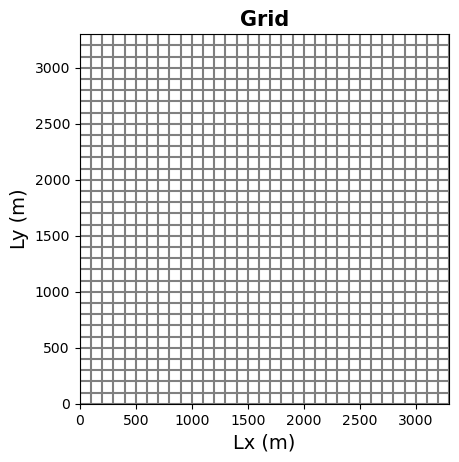

In [8]:
#use flopy to plot the grid of model 'm'
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid() 
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.show()

## 4. Define boundary conditions and initial conditions (BAS)

### 4.1 Define boundary conditions using IBOUND

#### 4.1a: Set up constant head cells

In [9]:
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)  

#set constant head boundaries
ibound[:,:,0] = -1          
ibound[:,:,-1] = -1          

In [10]:
H_west = 195.0
H_east = 149.0
H_init = np.zeros((nlay, nrow, ncol), dtype=np.float32)
for j in range(ncol):
    frac = j / (ncol - 1)
    H_init[:, :, j] = H_west + frac * (H_east - H_west)

In [11]:
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#### 4.1b: Plot model grid with boundaries to confirm

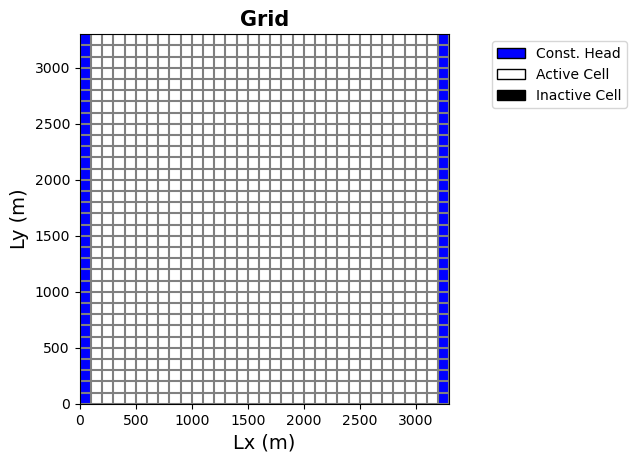

In [12]:
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()

plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)

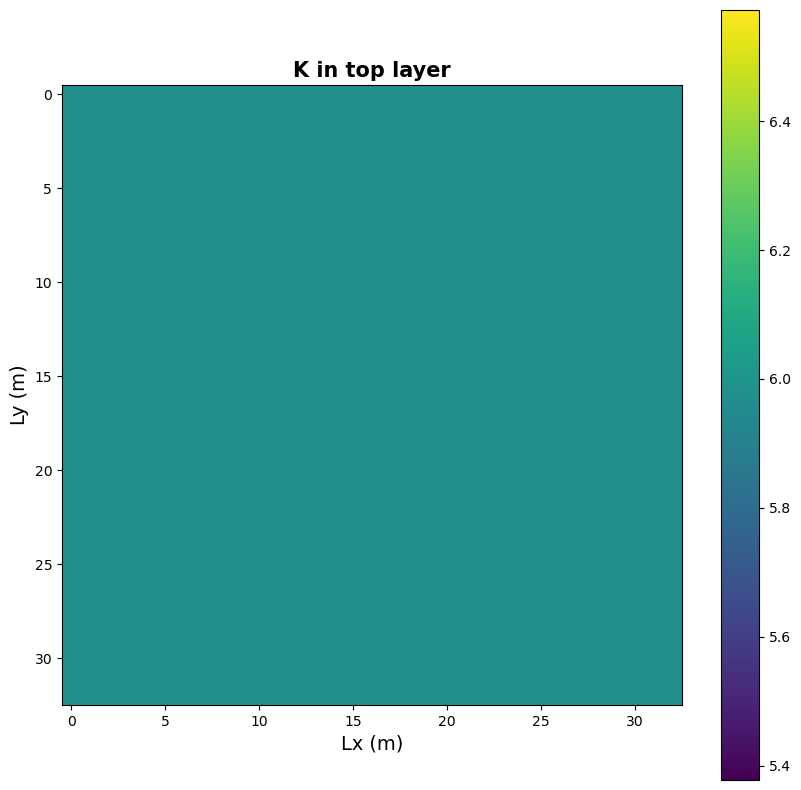

In [13]:
#K_vals is the top half Kh
#K_incl is the bottom half Kh
K_vals = np.zeros((nlay,nrow,ncol))
K_vals[:,:,:] = 5.975            
#K_incl = 1.25 # K inclusion value
#K_vals[:, 0:16, 0:33] = K_incl 


n = 0.3        #assign porosity
Ss = 0.0003      #assign storage coefficient
Sy = 0.12        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

#plot K values in top layer
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('K in top layer', fontsize = 15, fontweight = 'bold')
plt.imshow(np.flipud(K_vals[0,:,:]), interpolation='none')
plt.colorbar()
plt.show()

In [14]:
#assigns horizontal and vertical Ks and saves cell-by-cell budget data
bcf = flopy.modflow.ModflowBcf(m, ipakcb=53, intercellt=0, laycon=3, 
                               trpy=1.0, hdry=-1e+30, iwdflg=0, wetfct=0.1, 
                               iwetit=1, ihdwet=0, tran=1.0, hy=K_vals[0,:,:], 
                               vcont=1.0, sf1=Ss, sf2=Sy, wetdry=-0.01, extension='bcf', 
                               unitnumber=None, filenames=None) 


## 5. Input farm and well locations, define scenarios

### 5.1: Define farm locations

In [15]:
# Coordinate convention in the handout: (latitude, longitude) => (y, x)
ACME_SW_yx = (300, 1000)        # (y, x) in meters
WILDCAT_SW_yx = (1800, 425)  # (y, x) in meters

# Convert SW corners from (y,x) to (x,y)
acme_x0, acme_y0 = ACME_SW_yx[1], ACME_SW_yx[0]
wildcat_x0_raw, wildcat_y0 = WILDCAT_SW_yx[1], WILDCAT_SW_yx[0]

# Snap Wildcat x0 to grid (so its bounds are multiples of 100 m)
wildcat_x0 = 100.0 

# Farm bounds (x_min, x_max, y_min, y_max) in meters (all multiples of 100)
acme_bounds    = (1100, 2100, 500, 2500)  # 10 cols x 20 rows
wildcat_bounds = (500, 900, 2000, 2400)  # 4 cols x 4 rows

In [16]:
print("ACME bounds (x_min, x_max, y_min, y_max) [m]:", acme_bounds)
print("Wildcat bounds (x_min, x_max, y_min, y_max) [m]:", wildcat_bounds)

ACME bounds (x_min, x_max, y_min, y_max) [m]: (1100, 2100, 500, 2500)
Wildcat bounds (x_min, x_max, y_min, y_max) [m]: (500, 900, 2000, 2400)


In [17]:
# Convert (x,y) in meters to (row, col) for MODFLOW
def xy_to_rc(x, y, dx=dx, dy=dy, Ly=Ly):
    col = int(np.floor(x / dx))
    row = int(np.floor((Ly - y) / dy))  # row 0 at top of model
    return row, col

def inside_bounds(x, y, bounds):
    x0, x1, y0, y1 = bounds
    return (x0 <= x <= x1) and (y0 <= y <= y1)

def assert_min_spacing_xy(xy_list, min_dist_m=200.0):
    for i in range(len(xy_list)):
        for j in range(i+1, len(xy_list)):
            dx_ = xy_list[i][0] - xy_list[j][0]
            dy_ = xy_list[i][1] - xy_list[j][1]
            d = np.sqrt(dx_**2 + dy_**2)
            if d < min_dist_m:
                raise ValueError(f"Wells too close: {d:.1f} m < {min_dist_m} m between {xy_list[i]} and {xy_list[j]}")

### 5.2: Define scenarios

In [18]:
# Spacing constraint: >= 200 m (2 cells)
scenarios = {
    "baseline_middle": {
        "acme_wells_xy": [(1500, 1300), (1700, 1300)],
        "note": "Two ACME wells in the middle of ACME footprint (200 m spacing)."
    },
    "best_for_wildcat_far": {
        "acme_wells_xy": [(2000, 600), (2000, 800)],
        "note": "Two ACME wells as far from Wildcat as possible (SE corner of ACME)."
    },
    "worst_for_wildcat_near": {
        "acme_wells_xy": [(1100, 2300), (1300, 2300)],
        "note": "Two ACME wells as close to Wildcat as possible (W side of ACME, near Wildcat y-band)."
    }
}

In [19]:
for name, cfg in scenarios.items():
    wells_xy = cfg["acme_wells_xy"]
    assert_min_spacing_xy(wells_xy, min_dist_m=200.0)
    for (xw, yw) in wells_xy:
        if not inside_bounds(xw, yw, acme_bounds):
            raise ValueError(f"{name}: well {(xw, yw)} is outside ACME bounds {acme_bounds}")
        if not (0.0 <= xw <= Lx and 0.0 <= yw <= Ly):
            raise ValueError(f"{name}: well {(xw, yw)} is outside model domain 0..{Lx},0..{Ly}")
    cfg["acme_wells_rc"] = [(0, *xy_to_rc(xw, yw)) for (xw, yw) in wells_xy]  # (lay,row,col)
    print(f"\n{name}: {cfg['note']}")
    print("  ACME wells", wells_xy)
    print("  ACME wells", cfg["acme_wells_rc"])


baseline_middle: Two ACME wells in the middle of ACME footprint (200 m spacing).
  ACME wells [(1500, 1300), (1700, 1300)]
  ACME wells [(0, 20, 15), (0, 20, 17)]

best_for_wildcat_far: Two ACME wells as far from Wildcat as possible (SE corner of ACME).
  ACME wells [(2000, 600), (2000, 800)]
  ACME wells [(0, 27, 20), (0, 25, 20)]

worst_for_wildcat_near: Two ACME wells as close to Wildcat as possible (W side of ACME, near Wildcat y-band).
  ACME wells [(1100, 2300), (1300, 2300)]
  ACME wells [(0, 10, 11), (0, 10, 13)]


### 5.3: Define farm cells and recharge values

In [20]:
# Note: net recharge (1e-4 m/day) applies ONLY to non-irrigated areas (i.e., everywhere except the farms).
R_background = 1e-4  # m/day

# cell-center coordinates
x_centers = (np.arange(ncol) + 0.5) * dx
y_centers = Ly - (np.arange(nrow) + 0.5) * dy
Xc, Yc = np.meshgrid(x_centers, y_centers)

def bounds_mask(bounds):
    x0, x1, y0, y1 = bounds
    return (Xc >= x0) & (Xc <= x1) & (Yc >= y0) & (Yc <= y1)

acme_mask = bounds_mask(acme_bounds)
wildcat_mask = bounds_mask(wildcat_bounds)
non_irrigated_mask = ~(acme_mask | wildcat_mask)

# Recharge array for RCH package (nrow, ncol)
rech = np.zeros((nrow, ncol), dtype=float)
rech[non_irrigated_mask] = R_background

# Quick water-balance numbers (recharge only; pumping computed later)
cell_area = dx * dy
Q_recharge_m3_per_day = rech.sum() * cell_area
print(f'Recharge total (non-irrigated only): {Q_recharge_m3_per_day:,.1f} m^3/day')
print(f'Cells in ACME mask: {acme_mask.sum()}, Wildcat mask: {wildcat_mask.sum()}, non-irrigated: {non_irrigated_mask.sum()}')


Recharge total (non-irrigated only): 873.0 m^3/day
Cells in ACME mask: 200, Wildcat mask: 16, non-irrigated: 873


In [21]:
rch = flopy.modflow.ModflowRch(m, rech=rech)

### 5.4: Plot model grid area showing farm locations

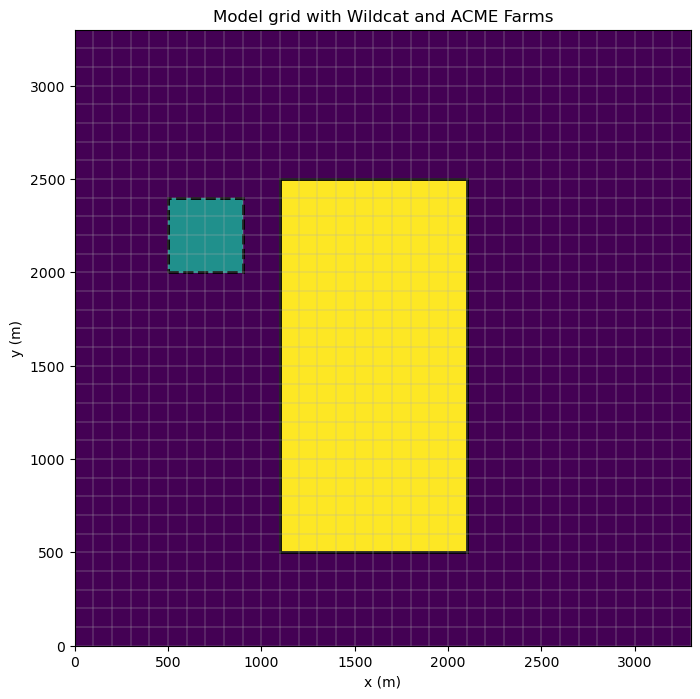

In [22]:
# Code map: 0 = non-farm, 1 = Wildcat, 2 = ACME
farm_code = np.zeros((nrow, ncol), dtype=int)
farm_code[wildcat_mask] = 1
farm_code[acme_mask] = 2

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

# Show farm code as an image; overlay gridlines
im = ax.imshow(farm_code, origin="upper", extent=(0, Lx, 0, Ly), interpolation="none")
#plt.colorbar(im, ax=ax, shrink=0.8, label="Farm code (0=non, 1=Wildcat, 2=ACME)")

# Gridlines every 100 m
ax.set_xticks(np.arange(0, Lx+1, dx), minor=True)
ax.set_yticks(np.arange(0, Ly+1, dy), minor=True)
ax.grid(which="minor", linewidth=0.3)
ax.tick_params(which="minor", bottom=False, left=False)

ax.xaxis.remove_overlapping_locs = False 
ax.yaxis.remove_overlapping_locs = False 


# Farm outlines (for clarity)
acme_rect = mpatches.Rectangle((acme_bounds[0], acme_bounds[2]),
                               acme_bounds[1]-acme_bounds[0],
                               acme_bounds[3]-acme_bounds[2],
                               fill=False, linewidth=2)
wildcat_rect = mpatches.Rectangle((wildcat_bounds[0], wildcat_bounds[2]),
                                  wildcat_bounds[1]-wildcat_bounds[0],
                                  wildcat_bounds[3]-wildcat_bounds[2],
                                  fill=False, linewidth=2, linestyle="--")

ax.add_patch(acme_rect)
ax.add_patch(wildcat_rect)

ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
ax.set_title("Model grid with Wildcat and ACME Farms")
plt.show()

## 6. Set up pumping rates, well locations, choose scenario

### 6.1: Define pumping rates

In [23]:
# Pumping rates taken from consumptive water use (in/yr) * farm area.
inches_m = 0.0254
cotton_in_per_yr = 41.2   # ACME grows cotton
alfalfa_in_per_yr = 74.3  # Wildcat grows alfalfa

def depth_m_per_day(in_per_yr):
    return (in_per_yr * inches_m) / 365.0

# Use model area not acres
cell_area_m2 = dx * dy
acme_area_m2_model = float(acme_mask.sum() * cell_area_m2)
wildcat_area_m2_model = float(wildcat_mask.sum() * cell_area_m2)

# Convert to volume (m^3/day)
Q_acme_total = depth_m_per_day(cotton_in_per_yr)  * acme_area_m2_model      
Q_wildcat    = depth_m_per_day(alfalfa_in_per_yr) * wildcat_area_m2_model   
Q_acme_each = Q_acme_total / 2.0

print(f"ACME model area: {acme_area_m2_model:,.0f} m^2  (cells={int(acme_mask.sum())})")
print(f"Wildcat model area: {wildcat_area_m2_model:,.0f} m^2  (cells={int(wildcat_mask.sum())})")
print(f"ACME total pumping (2 wells combined): {Q_acme_total:,.1f} m^3/day (each {Q_acme_each:,.1f})")
print(f"Wildcat pumping (1 well): {Q_wildcat:,.1f} m^3/day")

ACME model area: 2,000,000 m^2  (cells=200)
Wildcat model area: 160,000 m^2  (cells=16)
ACME total pumping (2 wells combined): 5,734.1 m^3/day (each 2,867.1)
Wildcat pumping (1 well): 827.3 m^3/day


### 6.2: Place Wildcat Farm well at center

In [24]:
# Wildcat well at center of farm
wildcat_xc = 0.5 * (wildcat_bounds[0] + wildcat_bounds[1])
wildcat_yc = 0.5 * (wildcat_bounds[2] + wildcat_bounds[3])
wildcat_row, wildcat_col = xy_to_rc(wildcat_xc, wildcat_yc)

### 6.3: Select scenario

In [25]:
# The three options: baseline_middle, best_for_wildcat_far, worst_for_wildcat_near
scenario_name = 'worst_for_wildcat_near'  # options: baseline_middle, best_for_wildcat_far, worst_for_wildcat_near
acme_wells_rc = scenarios[scenario_name]['acme_wells_rc']

### 6.4: Define stress periods

In [26]:
# Build WEL stress period data (negative for pumping/extraction)
wel_spd = []
# Wildcat (always on)
wel_spd.append([0, wildcat_row, wildcat_col, -Q_wildcat])
# Two ACME wells
for (lay, r, c) in acme_wells_rc:
    wel_spd.append([lay, r, c, -Q_acme_each])

wel = flopy.modflow.ModflowWel(m, stress_period_data={0: wel_spd})

In [27]:
#(0,0) tells OC package to save data for stress period 1, time step 1.
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 

print("oc stress period data: \n", spd)

oc stress period data: 
 {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}


In [28]:
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

In [29]:
pcg = flopy.modflow.ModflowPcg(model=m)

## 7. Print water budget data

In [30]:
Q_pump_total = Q_wildcat + Q_acme_total
print(f"Scenario: {scenario_name} -> {scenarios[scenario_name]['note']}")
print(f'Wildcat pumping: {Q_wildcat:,.1f} m^3/day')
print(f'ACME total pumping (2 wells): {Q_acme_total:,.1f} m^3/day (each {Q_acme_each:,.1f})')
print(f'Total pumping: {Q_pump_total:,.1f} m^3/day')
print(f'Recharge (non-irrigated only): {Q_recharge_m3_per_day:,.1f} m^3/day')

Scenario: worst_for_wildcat_near -> Two ACME wells as close to Wildcat as possible (W side of ACME, near Wildcat y-band).
Wildcat pumping: 827.3 m^3/day
ACME total pumping (2 wells): 5,734.1 m^3/day (each 2,867.1)
Total pumping: 6,561.4 m^3/day
Recharge (non-irrigated only): 873.0 m^3/day


## 8. Run model, print outputs

### 8.1: Run MODLFOW executable

In [31]:
m.write_input()

In [32]:
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: ../../../modflow/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Wildcat_Farm_2026.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2026/02/11 19:39:03

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2026/02/11 19:39:03
 Elapsed run time:  0.022 Seconds

 FAILED TO MEET SOLVER CONVERGENCE CRITERIA            1  TIME(S)


Exception: MODFLOW did not terminate normally.

In [ ]:
print(mfoutput)

['', '                                  MODFLOW-2005     ', '    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL', '                             Version 1.12.00 2/3/2017                        ', '', ' Using NAME file: Wildcat_Farm_2026.nam ', ' Run start date and time (yyyy/mm/dd hh:mm:ss): 2026/02/11 19:22:21', '', ' Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.', ' Run end date and time (yyyy/mm/dd hh:mm:ss): 2026/02/11 19:22:21', ' Elapsed run time:  0.064 Seconds', '', ' FAILED TO MEET SOLVER CONVERGENCE CRITERIA            1  TIME(S)']


In [ ]:
ls -l Wildcat_Farm_2026.*
less Wildcat_Farm_2026.lst
less Wildcat_Farm_2026.nam

SyntaxError: invalid syntax (1833390891.py, line 1)

In [ ]:
ls -l ../../../modflow/mf2005
file ../../../modflow/mf2005

SyntaxError: invalid syntax (388511648.py, line 1)

In [ ]:
headobj = bf.HeadFile(modelname+'.hds')    #reads the binary head file
times = headobj.get_times()                #returns a list of timesteps
head = headobj.get_data(totim=times[-1])        #returns a numpy array of heads for specified time (last timestep)

In [ ]:
with open('FP_heads.csv', 'w', newline='') as csvfile:  #creates an empty csv file called FP_heads
    writer = csv.writer(csvfile, delimiter=',')        
    for i in range(len(head[0,:,0])):                    #writes each row
        writer.writerow(head[0,i,:])

In [ ]:
budgobj = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
kstpkper_list = budgobj.get_kstpkper()          #returns a list of stress periods & timesteps
frf = budgobj.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells     
         #string options are in the list file under output control (make sure to include spaces!)

In [ ]:
flux_vals=np.squeeze(frf)
leftflux = flux_vals[:,0]
rightflux = flux_vals[:,-2]
#centerflux = flux_vals[:,12]
centerflux = flux_vals[:,2]

bdryflux_fig = plt.figure() 
x=np.arange(0,ncol*dx,dx) 
plt.plot(x,leftflux,marker='o', color='red', markersize=4, linestyle='-',label="left boundary")
plt.plot(x,rightflux,marker='x', color='blue', markersize=4, linestyle='--',label="right boundary")
plt.plot(x,centerflux,marker='x', color='green', markersize=4, linestyle='--',label="center")
plt.xlabel('Y location [m]')
plt.ylabel('Flow [m3/day]')
plt.title("Boundary Flows")
plt.legend()
plt.show()

In [ ]:
#Calculate the total flux across the model
flux_tot  = np.sum(flux_vals[:, 0]) #total flux through one column of the model [m3/day]

# Calculate the equivalent K (q=k*A* dh/dl)
area = nrow *dy * (ztop-zbot)
dh_dl= (H_init[0,0,0]-H_init[0,0,-1])/Lx
k_eff = flux_tot/area/dh_dl

# Calculate the arithmetic mean K
k_arr = np.mean(K_vals)

# Calcualte the harmonic mean K
k_harm = hmean(K_vals.flatten()) 

In [ ]:
#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
ax = fig_3d.add_subplot(111,projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[0])

surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Model Head Profile', fontsize=15, fontweight='bold')


In [ ]:
#Calculate the volumetric discharge
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
    (frf[0], fff[0], None), m) 

#plot first contour plot
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head[0].min(),head[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
quiver = modelmap.plot_vector(qx, qy)

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Steady-State Model, Flow(m^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)


In [ ]:
# Head at Wildcat well cell
h_wildcat = float(head[0, wildcat_row, wildcat_col])

# "Well goes dry" check (unconfined): dry if head falls below screen intake elevation
screen_depth_m = 20.0
h_screen = ztop - screen_depth_m  # screen intake elevation (m)

margin_m = h_wildcat - h_screen

status = "OK (water above screen)" if h_wildcat >= h_screen else "DRY (below screen)"
print("\n=== Wildcat depletion check ===")
print(f"Scenario: {scenario_name}")
print(f"Wildcat well cell (row,col): ({wildcat_row}, {wildcat_col})")
print(f"Simulated head at Wildcat well: {h_wildcat:.2f} m")
print(f"Screen elevation (approx): {h_screen:.2f} m  (20 m below land surface datum)")
print(f"Margin (head - screen): {margin_m:.2f} m  --> {status}")

In [ ]:
# Coordinates for plotting well markers (cell centers)
def rc_to_xy_center(row, col, dx=dx, dy=dy, Ly=Ly):
    x = (col + 0.5) * dx
    y = Ly - (row + 0.5) * dy
    return x, y

wildcat_xy_plot = rc_to_xy_center(wildcat_row, wildcat_col)
acme_xy_plot = [rc_to_xy_center(r, c) for (_, r, c) in acme_wells_rc]

# Clean contour map with farm outlines + well markers
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)

pmv = flopy.plot.PlotMapView(model=m, layer=0, ax=ax)

# Head contours
levels = np.linspace(np.nanmin(head[0]), np.nanmax(head[0]), 11)
cs = pmv.contour_array(head[0], levels=levels)
plt.clabel(cs, inline=1, fontsize=9)

# Specific discharge vectors (optional; comment out for a cleaner figure)
try:
    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge((frf[0], fff[0], None), m)
    pmv.plot_vector(qx, qy, istep=2, jstep=2)
except Exception as e:
    print("Note: could not plot specific discharge vectors:", e)

# Farm outlines
acme_rect = mpatches.Rectangle((acme_bounds[0], acme_bounds[2]),
                               acme_bounds[1]-acme_bounds[0],
                               acme_bounds[3]-acme_bounds[2],
                               fill=False, linewidth=2, edgecolor='k')
wildcat_rect = mpatches.Rectangle((wildcat_bounds[0], wildcat_bounds[2]),
                                  wildcat_bounds[1]-wildcat_bounds[0],
                                  wildcat_bounds[3]-wildcat_bounds[2],
                                  fill=False, linewidth=2, edgecolor='k', linestyle='--')
ax.add_patch(acme_rect)
ax.add_patch(wildcat_rect)

# Well markers
ax.scatter([wildcat_xy_plot[0]], [wildcat_xy_plot[1]], marker='*', s=200, label='Wildcat well')
ax.scatter([p[0] for p in acme_xy_plot], [p[1] for p in acme_xy_plot], marker='o', s=120, label='ACME wells')

# Labels + limits
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
ax.set_title(f"Head contours with wells | Scenario: {scenario_name}")
ax.legend(loc="lower left")

In [ ]:
# Head at Wildcat well cell
h_wildcat = float(head[0, wildcat_row, wildcat_col])

# "Well goes dry" check (unconfined): dry if head falls below screen intake elevation
screen_depth_m = 20.0
h_screen = ztop - screen_depth_m  # screen intake elevation (m)

margin_m = h_wildcat - h_screen

status = "OK (water above screen)" if h_wildcat >= h_screen else "DRY (below screen)"
print("\n=== Wildcat depletion check ===")
print(f"Scenario: {scenario_name}")
print(f"Wildcat well cell (row,col): ({wildcat_row}, {wildcat_col})")
print(f"Simulated head at Wildcat well: {h_wildcat:.2f} m")
print(f"Screen elevation (approx): {h_screen:.2f} m  (20 m below land surface datum)")
print(f"Margin (head - screen): {margin_m:.2f} m  --> {status}")

In [ ]:
strt=H_init[0]  # initial head surface (nrow x ncol)
drawdown = strt[0] - head[0]

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)
pmv = flopy.plot.PlotMapView(model=m, layer=0, ax=ax)

# Drawdown as a color scale
arr = pmv.plot_array(drawdown)
plt.colorbar(arr, ax=ax, shrink=0.8, label="Drawdown (m) = start head - simulated head")

# Farm outlines
acme_rect = mpatches.Rectangle((acme_bounds[0], acme_bounds[2]),
                               acme_bounds[1]-acme_bounds[0],
                               acme_bounds[3]-acme_bounds[2],
                               fill=False, linewidth=2)
wildcat_rect = mpatches.Rectangle((wildcat_bounds[0], wildcat_bounds[2]),
                                  wildcat_bounds[1]-wildcat_bounds[0],
                                  wildcat_bounds[3]-wildcat_bounds[2],
                                  fill=False, linewidth=2, linestyle='--')
ax.add_patch(acme_rect)
ax.add_patch(wildcat_rect)

# Well markers
ax.scatter([wildcat_xy_plot[0]], [wildcat_xy_plot[1]], marker='*', s=200, label='Wildcat well')
ax.scatter([p[0] for p in acme_xy_plot], [p[1] for p in acme_xy_plot], marker='o', s=120, label='ACME wells')

ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
ax.set_title(f"Depletion (drawdown) map | Scenario: {scenario_name}")
ax.legend(loc="lower left")